In [2]:
#dataset Splitting

import splitfolders
input_folder="D:\\deeplearning\\scratches\\data\\note_dataset"
output_folder = 'scratches/data/note_dataset_splitted'
splitfolders.ratio(input_folder,output="dataset",seed=42,ratio=(.7,.2,.1),group_prefix=None)

Copying files: 4583 files [00:18, 262.78 files/s]

KeyboardInterrupt: 

In [3]:
dataset_path = 'D:\\deeplearning\\scratches\\data\\note_dataset_splitted'

In [4]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from sklearn.model_selection import KFold
import random

In [5]:
import os
print(os.listdir(dataset_path))
classes = os.listdir(dataset_path + "/train")
print(classes)
print(len(classes))

['test', 'train', 'val']
['10', '100', '1000', '2', '20', '5', '50', '500']
8


In [6]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
from torchvision.datasets import ImageFolder
train_ds = ImageFolder(dataset_path+'/train',transform=train_transforms)
valid_ds= ImageFolder(dataset_path+'/val',transform=val_transforms)
len(train_ds)
len(valid_ds)

14105

In [10]:
dataset = ConcatDataset([train_ds,valid_ds])

In [11]:
batch_size=100
data_loader = DataLoader(dataset, batch_size=100, shuffle=True)


In [12]:
model = models.resnet50(pretrained=True)

C:\Users\mohib\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mohib\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
device

device(type='cuda', index=0)

In [16]:
val_accs=[]
val_losses=[]
train_losses=[]

In [18]:
from tqdm import tqdm
import time
import numpy as np
k=5
splits=KFold(n_splits=k,shuffle=True,random_state=42)
num_epoch=4
torch.manual_seed(42)

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    print('train size: ',len(train_sampler), 'test_sampler: ',len(test_sampler))

    for epoch in range(num_epoch):
        model.train()
        running_loss = 0.0

        t_start = time.time()

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} - Training", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_sampler)
        train_losses.append(epoch_loss) # for storing history

        # Validate model
        model.eval()
        val_loss = 0.0
        val_correct = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc=f"Epoch {epoch+1} - Validation", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)

        val_loss = val_loss / len(test_sampler)
        val_acc = val_correct.double() / len(test_sampler)

        #for storing history
        val_accs.append(val_acc)
        val_losses.append(val_loss)

        t_end = time.time()
        epoch_time = t_end - t_start

        print(f"Epoch {epoch+1} | Train Loss: {epoch_loss:.3f} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f} | Time: {epoch_time:.2f}s")

Fold 1
train size:  50784 test_sampler:  12696


Epoch 1 | Train Loss: 0.083 | Val Loss: 0.029 | Val Acc: 0.997 | Time: 392.29s


Epoch 2 | Train Loss: 0.026 | Val Loss: 0.015 | Val Acc: 0.998 | Time: 295.89s


Epoch 3 | Train Loss: 0.015 | Val Loss: 0.009 | Val Acc: 0.999 | Time: 281.30s


Epoch 4 | Train Loss: 0.010 | Val Loss: 0.007 | Val Acc: 0.999 | Time: 293.01s
Fold 2
train size:  50784 test_sampler:  12696


Epoch 1 | Train Loss: 0.008 | Val Loss: 0.006 | Val Acc: 0.999 | Time: 267.31s


Epoch 2 | Train Loss: 0.007 | Val Loss: 0.005 | Val Acc: 0.999 | Time: 235.84s


Epoch 3 | Train Loss: 0.006 | Val Loss: 0.004 | Val Acc: 0.999 | Time: 188.94s


Epoch 4 | Train Loss: 0.005 | Val Loss: 0.003 | Val Acc: 1.000 | Time: 183.04s
Fold 3
train size:  50784 test_sampler:  12696


Epoch 1 | Train Loss: 0.004 | Val Loss: 0.003 | Val Acc: 1.000 | Time: 180.71s


Epoch 2 | Train Loss: 0.004 | Val Loss: 0.002 | Val Acc: 1.000 | Time: 184.07s


Epoch 3 | Train Loss: 0.004 | Val Loss: 0.003 | Val Acc: 0.999 | Time: 185.94s


Epoch 4 | Train Loss: 0.004 | Val Loss: 0.003 | Val Acc: 0.999 | Time: 188.17s
Fold 4
train size:  50784 test_sampler:  12696


Epoch 1 | Train Loss: 0.003 | Val Loss: 0.005 | Val Acc: 0.999 | Time: 186.39s


Epoch 2 | Train Loss: 0.003 | Val Loss: 0.002 | Val Acc: 1.000 | Time: 191.23s


Epoch 3 | Train Loss: 0.003 | Val Loss: 0.005 | Val Acc: 0.998 | Time: 195.58s


Epoch 4 | Train Loss: 0.003 | Val Loss: 0.001 | Val Acc: 1.000 | Time: 192.15s
Fold 5
train size:  50784 test_sampler:  12696


Epoch 1 | Train Loss: 0.003 | Val Loss: 0.002 | Val Acc: 1.000 | Time: 184.51s


Epoch 2 | Train Loss: 0.002 | Val Loss: 0.004 | Val Acc: 0.999 | Time: 183.04s


Epoch 3 | Train Loss: 0.002 | Val Loss: 0.001 | Val Acc: 1.000 | Time: 183.48s


Epoch 4 | Train Loss: 0.002 | Val Loss: 0.001 | Val Acc: 1.000 | Time: 189.53s


In [19]:
  test_transforms = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(dataset_path+'/test', transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [30]:
train_losses,val_losses,val_accs
val_accs =torch.tensor(val_accs)
val_accs=val_accs.tolist()

C:\Users\mohib\AppData\Local\Temp\ipykernel_14712\1980251505.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_accs =torch.tensor(val_accs)


In [21]:

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {(correct/total)*100}%")

Accuracy on test set: 94.88813367318039%


In [30]:
val_accs = [0.9975,0.9986,0.9989,0.9993,0.9990]


[0.033737282390524335,
 0.01497295401262952,
 0.010401393233303276,
 0.00720926375861114,
 0.00516181531665262]

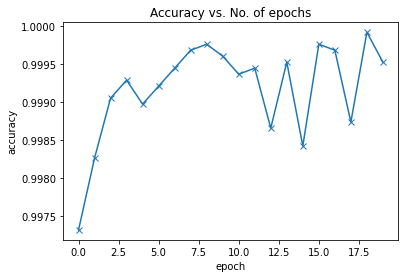

In [31]:
import matplotlib.pyplot as plt
def plot_accuracies(accuracy):

    plt.plot(val_accs, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
plot_accuracies(val_accs)

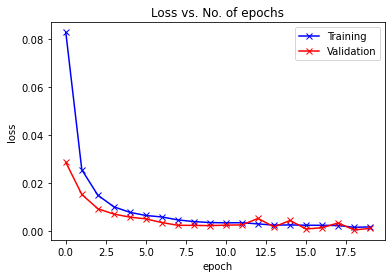

In [32]:
def plot_losses(trainloss,valloss):


    plt.plot(trainloss, '-bx')
    plt.plot(valloss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])

    plt.title('Loss vs. No. of epochs')
plot_losses(train_losses,val_losses)